In [66]:
import pandas as pd
import pymupdf
import re

In [67]:
doc = pymupdf.open("../data/raw/emp.pdf") # open a document

In [68]:
len(doc)

886

In [69]:
text = {"desc": {}, "bl_list": {}}
for i, page in enumerate(doc):
    i = i + 1  # Just for ease when comparing indexing to the pdf pages
    # Printed page numbers are the numbers printed on the page (from title page, then i - 858)
    # Actual page numbers are the 1 - 886 numbers of the pages in the pdf, do not correspond to number on the page
    # Remember that all actual page numbers in the pdf are one greater than the Python indexing
    if i == 1:
        section = None
    if i == 126:  # Page 98
        section = "desc"
    if i == 596:  # Page 568
        section = None
    # if i == 834:  # Page 806
    #     section = "bl_list"
    # if i == 849:  # Page 820
    #     break

    if section:
        page_num = i - 28
        page_text = page.get_text() # get plain text (is in UTF-8)
        text[section][i] = page_text

In [70]:
assert len(text["desc"]) == 470

In [71]:
full_desc = ""
for k, v in text["desc"].items():
    full_desc += v

In [72]:
len(full_desc)

1209688

In [73]:
with open("../data/interim/full_description.txt", "w", encoding="utf8") as f:
    f.write(full_desc)

In [74]:
early_header = []
for i in range(126, 596, 2):
    early_header.append(text["desc"][i].split("\n")[0])

desc_header = []
for i in range(127, 597, 2):
    desc_header.append(text["desc"][i].split("\n")[0])
99+256
283
has_page_num = []
for i in range (126, 595):
    has_page_num.append(text["desc"][i].count(str(i - 28)))

In [75]:
pd.Series(has_page_num).value_counts().sort_index()

0      1
1    449
2     10
3      8
4      1
Name: count, dtype: int64

I've investigate the below, in each instance the header was not transcribed, rather than transcribed in the wrong place, so current logic to remove it if present holds

In [76]:
[(i, e) for i, e in enumerate(early_header) if "EARL" not in e]

[(61, 'Donelang Sayang '),
 (111, '1906.b '),
 (126, 'Singapore '),
 (145, '123pp. (lp, [1], 1-123); ')]

In [77]:
emp_head_counts = pd.Series([e for e in early_header if "EARL" in e]).value_counts()
print(emp_head_counts.sum())
emp_head_counts

231


EARLY MALA Y PRINTED BOOKS      94
EARLY MALAY PRINTED BOOKS       38
EARLY MALA Y PRIN1ED BOOKS      29
EARLY MALAY PRIN1ED BOOKS       13
EARLY MALA Y PRINlED BOOKS       9
EARLY~YPRThITEDBOOKS             8
EARLY MALAY PRImED BOOKS         6
EARLY MALA Y PRINIED BOOKS       4
EARLY MALAY PRINfED BOOKS        3
EARLY MALAY PRINlED BOOKS        3
EARLY MALA Y PRImED BOOKS        3
EARLY MALA Y PRINfED BOOKS       2
EARL Y MALAY PRIN1ED BOOKS       2
EARLY MALA Y PRIN1E) BOOKS       2
EARLY~YP~DBOOKS                  1
EARLYMALAYPRThITEDBOOKS          1
EARL Y MALAY PRlNfED BOOKS       1
EARL Y MALA Y PRINTED BOOKS      1
EARLY MAlA Y PRINlED BOOKS       1
EARLY~AYP~DBOOKS                 1
EARL Y MALAY PRINTED BOOKS       1
EARLY MALA Y PRIN1lID BOOKS      1
EARLY MAlA Y PRIN1ED BOOKS       1
EARLY MALA Y PRINrED BOOKS       1
EARLY MALA Y PRINffiD BOOKS      1
EARLY MAlA Y PRINTED BOOKS       1
EARLY MALA Y PRIN1ID BOOKS       1
EARLY MALA Y PRINrnD BOOKS       1
EARLY MALA Y PRJNIE)

The below is just some extra mistranscribed lines due to lines at the top of the photocopy, DESCRIPTION appears on the third line

In [78]:
[(i, d) for i, d in enumerate(desc_header) if "DESC" not in d]

[(128, '_ ')]

In [79]:
pd.Series([d for d in desc_header if "DESC" in d]).value_counts()

DESCRIPTION      220
DESCRIfYfION       4
DESCRIPI10N        2
DESCRlmON          1
DESCRlfYTION       1
DESCRIJYrION       1
DESCRIPfION        1
DESCRWflON         1
DESCRIYflON        1
DESCRIJYTION       1
DESCRlfYfION       1
Name: count, dtype: int64

### Pre-treat mistranscriptions

In [80]:
# bad header
if text["desc"][383][0] == "_":
    text["desc"][383] = text["desc"][383][10:]
assert text["desc"][383][:5] == "DESCR"

### Parsing the first page

In [81]:
split = text["desc"][126].split("\n")
if split[1] == "It should be assumed that the author/editor ":
    text["desc"][126] = "\n".join(split[9:49] + split[58:])
assert text["desc"][126][:5] == "Abbas"

### Parse columns on remaining pages

In [110]:
def process_page(page, page_num):
    trim_space = page.replace(" \n", "\n")
    split = trim_space.split("\n")
    lines = [l for l in split if l]
    if "DESC" in lines[0] or "EARL" in lines[0]:
        lines = lines[1:]

    if lines.count(page_num) == 1:
        lines.remove(page_num)

    return lines

In [111]:
processed_pages = []
for i in range(126, 596):
    page_num = str(i - 28)
    page = text["desc"][i]
    processed_pages.append(process_page(page=page, page_num=page_num))

In [140]:
for i, p in enumerate(processed_pages[:5]):
    with open(f"../data/processed/ground_truth/p{i+1}_column_parse.txt", encoding="utf8") as f:
        gt = [l.strip("\n") for l in f.readlines()]
        print(i + 1)
        print([a for a,b in zip(gt, p) if a!=b])
        assert gt == p

1
[]
2
[]
3
[]
4
[]
5
[]


In [136]:
print(text["desc"][130])

EARLY MALAY PRIN1ED BOOKS 
Melayu yang di dalam Singapura 
Pulau Pinang dan Melaka 
proprietor: Tuan Inspector of Schools, 
Straits Settlements 
publisher: Matba' Kelly & Walsh Ltd 
Singapore 
typeset jawi, on 22 x 14.5 cm pages in 
16.5 x 10 cm frame, with 20 lines per 
IIlge 
in 2 parts 
part 1 
printer and publisher: Kelly & Walsh 
Ltd :tp 
1911 
241pp. (3-241); [priced $0.40 per copy 
(1911-12), $0.70 per copy (1912-) 
:SSGG] 
part 2 
publisher: Kelly & Walsh Ltd :tp 
printer: Hazell, Watson & Viney Ltd, 
London & Aylesbury :btp 
1915 
245pp. (243-487); 
[priced $0.40 per 
copy :SSGG] 
References 
SSGG 12 January 1912, p.xxvi, 27 
December 1912, p.xxvi etc. (advertise-
ments) 
Locations 
BL OIOC 14653.d.46(1),(2) (IOLR 
Malay 030(1),(2» ; 
SOAS IBA920 65964; IBA920 2725 
[vol. 2 only] 
1914-125 
Hikayat Abdullah bin Abdul Kadir 
Munsyi 
publisher: Kelly & Walsh Ltd 
Singapore 
typeset jawi 
in 2 parts 
part 1 
1914 
'\ 
[priced $0.70 per copy :SSGG] 
part 2 
1915 
Note: 
part 1 may

In [102]:
df = pd.DataFrame(data=gt, columns=["gt"])
df["page"] = pd.Series(p)
df.head(40)

,gt,page
0,Abbas,Abbas
1,1837.a,1837.a
2,1st edition,1st edition
3,Cetera Hikayat Sayid Abbas ibn Sayid,Cetera Hikayat Sayid Abbas ibn Sayid
4,"Zain; .History of Said Abbas, or the","Zain; . History of Said Abbas, or the"
5,Sin of Murder,Sin of Murder
6,Penang,Penang
7,1837,1837
8,16pp.; in edition of 2500 copies,16pp.; in edition of 2500 copies
9,References,References


In [83]:
process_page(page=text["desc"][127], page_num="99")

['Reference',
 'SSGG 23 October 1896, p.1908, regis-',
 'tration 00.295',
 'a 1907',
 'Abdau Makna; Abdau Makna Salawat',
 'Jailani dan Syaikh Baidawi; Abdau',
 'dengan syarlmya Makna Melayu',
 "[? Singapore)'",
 '[before August 1907]',
 'References',
 'Indera Jaya 1905; Salawat al-Quran',
 '1905;',
 'Mukaddimah Nazm 1906',
 '(advertised as forthcoming); Cermin',
 'Islam 1907 (advertisement)',
 'Abdullah',
 '1849',
 '[lst edition]',
 'Hikayat Abdullah bin Abdul Kadir',
 'Munsyi :tp; Hikayat Abdullah :5;',
 'aIlllwr [&. copyist] : Abdullah b. Abdul',
 'Kadir Munsyi',
 'publishu: [B.P. Keasberry]',
 'prilller: [Bulcit Zion]',
 'Singapore',
 '[17 J umadilawal 1265 = 10 April 1849',
 ':1888 edition]; 22 October 1840 = 25',
 "Sya'ban 1256 :et",
 '441pp. (tp, 1-441);',
 'lithographed jawi',
 'with illustrations on 26 x 21.5 cm',
 'pages in cm frame 17.5 x 11.5 cm,',
 'with 15 lines per page; pages 1 & 2',
 'have wide coloured floral borders,',
 '[priced at $4.00 per copy :Hill]',
 'Notes:',


In [30]:
text["desc"][127].replace(" \n", "\n").split("\n")

['DESCRIPTION',
 'Reference',
 'SSGG 23 October 1896, p.1908, regis-',
 'tration 00.295',
 'a 1907',
 'Abdau Makna; Abdau Makna Salawat',
 'Jailani dan Syaikh Baidawi; Abdau',
 'dengan syarlmya Makna Melayu',
 "[? Singapore)'",
 '[before August 1907]',
 'References',
 'Indera Jaya 1905; Salawat al-Quran',
 '1905;',
 'Mukaddimah Nazm 1906',
 '(advertised as forthcoming); Cermin',
 'Islam 1907 (advertisement)',
 'Abdullah',
 '1849',
 '[lst edition]',
 'Hikayat Abdullah bin Abdul Kadir',
 'Munsyi :tp; Hikayat Abdullah :5;',
 'aIlllwr [&. copyist] : Abdullah b. Abdul',
 'Kadir Munsyi',
 'publishu: [B.P. Keasberry]',
 'prilller: [Bulcit Zion]',
 'Singapore',
 '[17 J umadilawal 1265 = 10 April 1849',
 ':1888 edition]; 22 October 1840 = 25',
 "Sya'ban 1256 :et",
 '441pp. (tp, 1-441);',
 'lithographed jawi',
 'with illustrations on 26 x 21.5 cm',
 'pages in cm frame 17.5 x 11.5 cm,',
 'with 15 lines per page; pages 1 & 2',
 'have wide coloured floral borders,',
 '[priced at $4.00 per copy :Hil

In [16]:
full_desc[:1000]

'EARLY MALAY PRINTED BOOKS \nIt should be assumed that the author/editor \nnamed in the Gazette memoranda of lithographs \ngenerally refers to the copyist. \nContemporary information from other \nsources, particularly from booksellers\' advert-\nisements and publishers\' notifications of other \ntitles in stock or in the press, has been used \ncautiously to supplement the information \nAbbas \n1837.a \n1st edition \nCetera Hikayat Sayid Abbas ibn Sayid \nZain; . History of Said Abbas, or the \nSin of Murder \nPenang \n1837 \n16pp.; in edition of 2500 copies \nReferences \nIbrahim, "Early Printing", pp.63-65 [as \n1838]; \nO\'Sullivan, \n"London \nMissionary \nSociety", p.92 [as 1838] \n1837.b \n2nd edition enlarged \nCetera Hikayat Sayid Abbas ibn Sayid \nZain Suaminya Cik Nurati yang \nSudah Bunuh Cik Minah Isteri Fu \nKa Mat dan Anak Tirinya bemama \nBasir di Tempat Bemamanya Batu \nMaung Dalam di Bandar Pulau \nPinang ... 7Pebruari 1837 \nauthor & publisher: Tuan Paderi Beighton \nP

In [17]:
a_re = re.compile(r"^C\s{0,2}$", flags=re.MULTILINE)
matches = []
for k, v in text["desc"].items():
    if a_re.findall(v):
        matches.append(v)

print(len(matches))

0


In [18]:
page_lengths = pd.Series([len(v) for v in text["desc"].values()])

<Axes: >

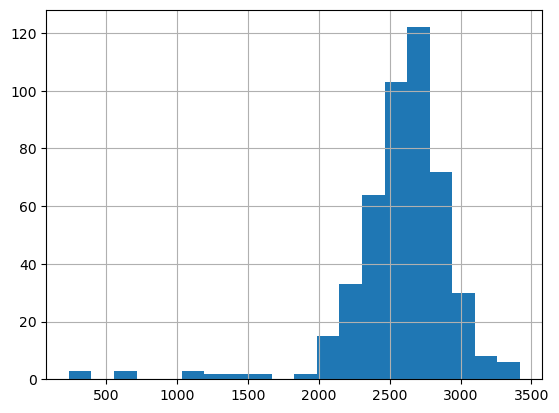

In [19]:
page_lengths.hist(bins=20)

In [92]:
[print(i, "content:", p) for i, p in text["desc"].items() if len(p) < 1000]

162 content: EARLY MALAY PRImED BOOKS 
Azlmat 
a 1891 
copyist: [? Ibrahim] 
publisher: [? Haji Muhammad ---, Lorong 
Masjid Sultan] 
[Singapore] 
[early 1891] 
lithographed jawi 
134 
Location 
BL OIOe 14620.f.3(1) [fragment in 
bindings of Kaifiyat Khatam Quran 
1891) 
b 1:1906 
[Azimat macam-macam] 
[after August 1905] 
Reference 
Salawat al-Quran 1905 (advertised as 
forthcoming) 

271 content: DESCRIPTION 
Location 
KITL V hh 279 @ UM fiche 89 [with 
Haji Muhammad Sirat as publisher in 
KKM] 
Gunanya Agama 
a 1888 
The Benefits of Religion 
publisher & printer: W.G. Shellabear 
Singapore 
1888 or soon after 
mimeographed, distributed free 
Reference 
Shellabear, "Life", p.32 
b 1900. 
Gunanya Agama 
243 
publisher: American Mission Press 
Singapore 
[OCfore February 1906] 
4pp.; jawi, distributed free 
Reference 
Orang yang Cari Seiamal1905, p.249 
GunturAlam 
a 
Hikayat Sultan Guntur Alam 
[? Singapore] 
[after December 1902] 
Reference 
Perang Selambu/ 1902 (advertised as 
forth

[None, None, None, None, None, None]

In [52]:
a_re = re.compile(r"^C\s{0,2}$", flags=re.MULTILINE)

In [53]:
a_re.findall(full_desc)

[]

In [47]:
full_desc.split("\nA \n")[1][-100:]

'(lp, 3-45); \nlithographed jawi, on \n20.5 x 13.5 cm pages, with around 20 \nlines per page \nContents: '

In [113]:
text["desc"][1100:1300]

'17 moral lessons, 22 hymns \nReferences \nIbrahim, "Early Printing", pp.63-65 [as \n1838], p.69 reproduces tp; \nO\'Sullivan, \n"London \nMissionary \nSociety", p.92 [implies 1839] \nA \n98 \nwhich can be drawn '

In [112]:
print(text["desc"][1100:5000])

17 moral lessons, 22 hymns 
References 
Ibrahim, "Early Printing", pp.63-65 [as 
1838], p.69 reproduces tp; 
O'Sullivan, 
"London 
Missionary 
Society", p.92 [implies 1839] 
A 
98 
which can be drawn from Gazette registrations 
and the extant books themselves. 
Sellers of books are noted separately only 
when they are not also their publishers. Only 
those sales agents mentioned on the books 
themselves are listed. not those who advertise 
the books for sale. 
Location 
SOAS EB:82:445 338322(18) 
Abdau 
1896 
Kitab Abdau :tp,col; Nazam Melayu :tp; 
author: [Ahmad al-Manuki] 
translator & proprietor: Haji Harnzah Kedah 
printer: Haji Muhammad Hasan 
Singapore 
21pp. (tp, 2-21); 
lithographed jawi, in 
Arabic & Malay on alternate lines, on 
21 x 16.5 cm pages in 17 x 12.5 cm 
frame, with 12 pairs of lines per page 
Contents: Arabic text with paraphrase in 
Malay verse, "menyatakan IImu Usul 
ai-Din" 
Notes: copyright notices on tp and p.21 
both appear to have been altered, 
formerly ass

In [80]:
print(text["desc"][-1000:])

:tp,col; Syair 
Zubaidah :ht2 
publisher & printer: Haji Muhammad Amin 
Singapore 
27 Jumadilakhir 1330 [June 1912]; 
Ramadhan 1306 [May 1889] :et 
277pp. (tp, 2-277); 
lithographed jawi, on 
24 x 17 cm pages in 20.5 x 11 cm 
frame 
Sold by: Kedai [Haji Muhammad Amin], 
Kampung Intan, di Bussorah Street 6 & 
8 :et 
Location 
ULC 843.31.c.90.3 < Evans 
567 
1915 
Syair Siti Zabidah 
Singapore 
1915 
[lithographed] 
Reference 
Winstedt, "Classical Malay Literature", 
p.322 
1919 
Syair Siti Zubaidah Perang Cina 
publisher: Muhammad Idris 
Singapore 
1919 
32Opp.; on 21 cm pages 
Reference 
Abdul Mutalib, Syair Siti Zubaidah 
Perang Cina, p.vi 
Location 
DB K 811.102 Si [not found] 
a 1920. 
Syair Siti Zubaidah Perang Cina 
proprietor: Haji Muhammad Amin b. Haji 
Abdullah 
publisher: Matbaah al-Aminiah, 6 & 7 
Baghdad Street 
Singapore 
[date missing; ? 1910s - 2Os] 
lithographed jawi, on 20 x 12 cm pages 
Location 
DB MSS 169 [incomplete: p.2, 16-15,71-
72,259-260,267-270,307-318 only] 


In [81]:
print(text["bl_list"][:2000])

EARLY MALA Y PRINTED BOOKS 
681 F 19 
682 E 23 
687.3 FOl 
687.3 F 11 
687.3 F lln 
687.3 F 12 
687.3 F 12 
687.3 F 12 
687.3 F 12 
690E 93 
690E96 
o 690E 97 
690E 98 
690E99 
690F03 
o 690F08 
690 F08a 
690 F08b 
690 F08c 
690 F09a 
690F lOa 
690F lOb 
690F 11 
690F 12 
690 F 12a 
690 F 16 
708 FOlb 
7('1) FOO 
720.1 E 77a 
720.1 E 77b 
720.1 E 79 
720.1 E 93 
720.1 E 96b 
720.1 F02 
720.1 F02b 
720.4 E 87(c) lE 98 
720.4 E 87a 1E98 
720.4 E 87b lE 98 
720.4 E 89 
720.4 E 91 
BL 
DM6557b 
DM6541 
DM2027 
DM2027a 
DM2027a 
DM2027a 
DM2027a 
DM2027a 
DM2027a 
DM 5816 
OM 5820 
DM5822 
DM 5823 
DM5824 
DM5825 
OM 5826b 
DM 5826an 
DM 5826an 
DM 5826an 
DM 5826a 
DM 5826b? 
DM 5826c? 
OM5826d 
DM5826dn 
OM 5826e 
DM 5826fn 
DM 5826f 
OM 5828b 
OM 9056 
DM 2163 
DM3469 
DM3469a 
DM3469d 
DM3469b 
DM 3469h 
DM 3469i 
DM 3461 
DM 3461 
Humanities and Social Sciences 
P.P.3801 
T.35*(15) 
T.1539/16 
T.2048(5) 
X.989n9766 
X.989n9766 (fonneriy 2059.g) 
622.f.36 
825.i.40 
1570/451 
Bible: Mat

In [82]:
print(text["bl_list"][-1000:])

 Sungai 1846 
Yusuf 1904 
Kalender 1920 
Tembakau 1919 
Madat 1919 
Makan Sirih 1919 
Alkohol 1919 
Habsyi 1841 
HaflZ ai-Islam 1899 
Dictionary: Wilkinson 1901 
Isa a 
Bible: Mark 1899.b 
Abdullah 1916 
Peringatan 1919 
Tangga Pengetahuan 1920 
Terasul 1914 
AnakRaja a 
Sultan Ibrahim a 
Anggun Cik Tunggal 1914 
Kamar al-Badri 1908 
? Laila Indera a 
Terasul 1920 
Miskin Marakarmah 1903 
Bustamam 1914 
Tanbih Tujuhbelas 1893 
TawadudJariah 1917 
Abdul Muluk c 
Cerita Jenaka 1914 
? Pegar Madi 1903 
Cendawan Putih 1900 
Hang Tuah 1917 
? Hang Tuah 1909 
Teka-Teki 1914 
? Pelajaran Bahasa Melayu 1900 
? Pelajaran Bahasa Melayu 1901 
Petuturan Melayu 1911 
Ilmu Kira-Kira 1898 
Bab al-Sihat 1910 
Johan Maligan 1919 
Empat Serangkai 1916 
Zubaidah 1919 
Taj al-Hadi 1903 
Ilmu Alam 1918 
Matahari Memancar 1906 
Salasilah Melayu dan Bugis 1911 
Sejarah Melayu 1915 
Sejarah Melayu 1910 
Sejarah Melayu 1896 
Johor 1920 
Gul Bakawali 1892 
Xiyou Ji 1911 
Lautan Akal 1907 
Bni Israil 1907 
820 


#### Get AG's columns

In [116]:
# alphabet = {l:i for i,l in enumerate(sorted(list(set(full_desc)))[33:59])}

alphabet = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'N': 13,
    'O': 14,
    'P': 15,
    'Q': 16,
    'R': 17,
    'S': 18,
    'T': 19,
    'U': 20,
    'V': 21,
    'W': 22,
    'X': 23,
    'Y': 24,
    'Z': 25
}

sample_df = pd.read_csv("../data/external/ALEPH sample Bollinger EMP.csv", encoding="utf8", nrows=13)
sample_df.drop(index=2, inplace=True)
cols = ["A", "E", "Q", "U", "AB", "AC", "AD", "AH", "AJ", "AQ", "AR", "CM"]

All before 1887 purchased, 1888 onwards legal deposit - AG

In [117]:
col_nums = []
for c in cols:
    if len(c) == 1:
        col_nums += [alphabet[c]]
    if len(c) == 2:
        d1 = 26 * (alphabet[c[0]] + 1)
        d2 = alphabet[c[1]]
        col_nums += [d1 + d2]

In [118]:
sample_df.columns[col_nums]

Index(['Shelfmark', 'Date 1', 'Name', 'Title', 'Place of publication',
       'Publisher', 'Date of publication in Arabic or Roman numerals',
       'Extent', 'Dimensions', 'General notes', 'Bibliography etc. note',
       'Method of acquisition'],
      dtype='object')

In [124]:
gt_df = sample_df.iloc[2:, col_nums].copy()
gt_df

,Shelfmark,Date 1,Name,Title,Place of publication,Publisher,Date of publication in Arabic or Roman numerals,Extent,Dimensions,General notes,Bibliography etc. note,Method of acquisition
3,14620.d.20(2),1826,"Robinson, William, 1784-1853",Ilmu falak,[Bencoolen],Tuan [N.M.] Ward,[1826],26 pages,21 cm,NaN,Proudfoot 1993: Ilmu Falak 1826,Purchased
4,14625.h.3,1840,"Abdullah, Munshi, 1796-1854","Hikayat Panja Tanderan, iaitu yang dinamai ole...",[Singapore],[publisher not identified],[1840],89 pages,29 cm,Lithographed,Proudfoot 1993: Galila Damina a,Purchased
5,14622.b.6,1864,"Rānīrī, Nūr al-Dīn, active 17th century",Sirat al-mustakim,Singapore,[publisher not identified],1864,1028 pages,21 cm,Lithographed,Proudfoot 1993: Sirat al-Mustakim 1864,Purchased
6,14620.g.16,1873,"Bidin, Haji",Kitab malkut al-syariah li-taklim al-sabiy wal...,[Singapore],[publisher not identified],1873,35 pages,20 cm,Lithographed,Proudfoot 1993: Malkut al-Syariat 1873,Purchased
7,14625.a.7,1889,"Tan, Beng Teck","Chreta dolu kala, dari pasal Heng Guan Seo-Chi...",Singapore,Chin Teck Bee & Co,1889,"60, 94, 34, 48 pages",17 cm,NaN,Proudfoot 1993: Erdu Mei 1889,Legal Deposit
8,14625.a.1,1892,"Luo, Guanzhong, approximately 1330-approximate...","Kasatu bijak lahsana, dari charita kesah 'Sam ...",Singapore,Chang Kim Boon,1892-1896,30 volumes; 4622 pages,16 cm,NaN,Proudfoot 1993: San Guo 1892-1896,Legal Deposit
9,14626.d.8,1903,Sharifah Alawi binti Sayid Teh al-Habsyi,Syair nasihat perempuan,Penang,Kulub Muhammad Saman b. Ayup,1903,29 pages,22 cm,NaN,Proudfoot 1993: Nasihat Perempuan 1903,Legal Deposit
10,14653.c.25,1906,"Abdul Rahman bin Haji Abdul Aziz, Haji",Kitab primbunan sembahyang supaya pada weruh w...,Singapore,"Muhammad Idris, al-Matbaah al-Idrisah al-waqi'...",1906,155 pages,21 cm,Lithographed,Proudfoot 1993: Primbunan Sembahyang 1906,Legal Deposit
11,14620.d.7,1905,"Bunyan, John, 1628-1688",Chrita orang yang chari slamat,Singapore,American Mission Press,1905,249 pages,21 cm,NaN,Proudfoot 1993: Orang yang Cari Selamat 1905,Legal Deposit
12,14633.e.3(2),1905,"Simon, G. K.",Buku parlajaran surat Bolanda. Sihap Si Malungun.,Singapore,American Mission Press,1905,30 pages,19 cm,NaN,Proudfoot 1993: Parlajaran Surat Bolanda 1905,Legal Deposit
